In [77]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [78]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
# base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'
base_path = '/home/nicholastey/gnss_spoof_detector/spoof_detector/data/'

In [79]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [80]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [81]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
print(big_df.shape)
print(big_df.columns)
print(big_df['spoofed'].value_counts(normalize=True))

big_df

(189272, 12)
Index(['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs',
       'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'pseudorange_m', 'rx_time', 'spoofed'],
      dtype='object')
spoofed
6    0.146963
5    0.146963
1    0.145272
4    0.143920
2    0.142060
3    0.138002
0    0.136819
Name: proportion, dtype: float64


,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [82]:
big_df.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)
big_df
print(big_df.shape)
print(big_df.columns)
print(big_df.isna().sum())


(189272, 7)
Index(['prn', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'rx_time', 'spoofed'],
      dtype='object')
prn                   0
prompt_i              0
prompt_q              0
cn0_db_hz             0
carrier_doppler_hz    0
rx_time               0
spoofed               0
dtype: int64


In [83]:
# Sort by PRN and rx_time (in case it's not already)
big_df = big_df.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
window_size = 1000

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'{col}_roll_mean'] = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df[f'{col}_roll_std']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df[f'{col}_roll_min']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df[f'{col}_roll_max']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std', 'cn0_db_hz_roll_min', 'cn0_db_hz_roll_max', 'carrier_doppler_hz_roll_mean', 'carrier_doppler_hz_roll_std', 'carrier_doppler_hz_roll_min', 'carrier_doppler_hz_roll_max']].head()



,prn,cn0_db_hz,carrier_doppler_hz,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max
6474,3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
6475,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'delta_{col}'] = big_df.groupby('prn')[col].diff().fillna(0)

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'delta_cn0_db_hz', 'delta_carrier_doppler_hz']].head()



,prn,cn0_db_hz,carrier_doppler_hz,delta_cn0_db_hz,delta_carrier_doppler_hz
6474,3,0.0,0.0,0.0,0.0
6475,3,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0


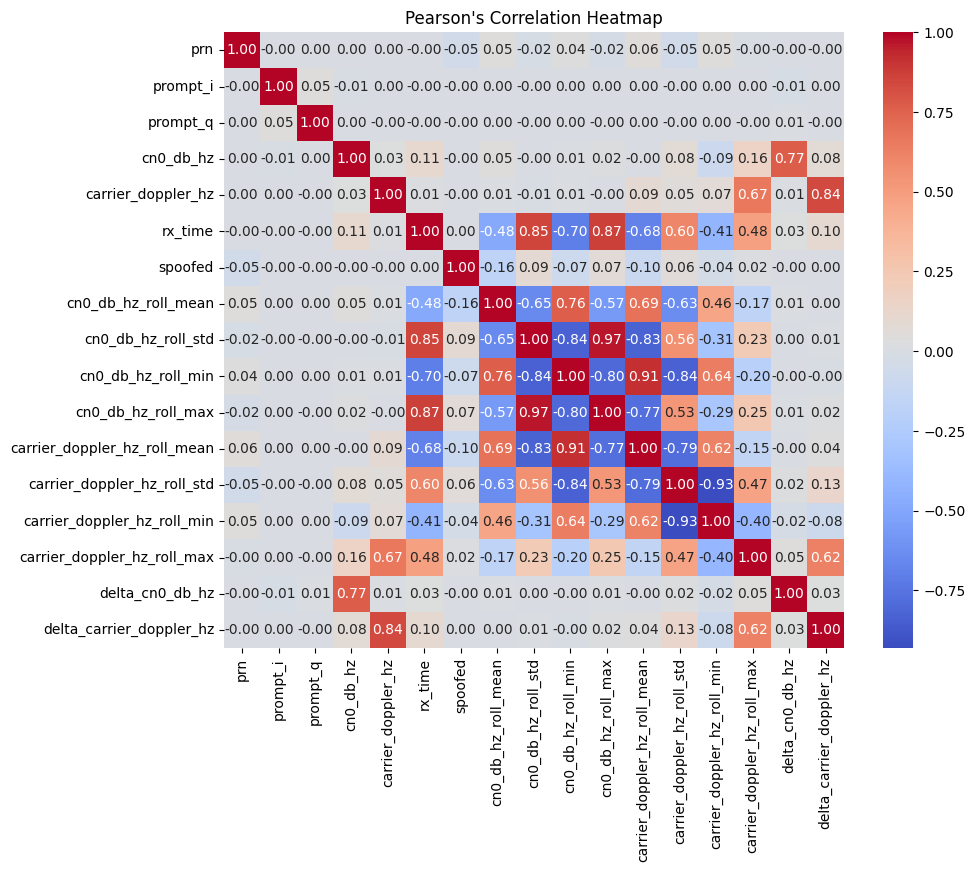

In [85]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [227]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [228]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [229]:
big_df_no_diff.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)

In [231]:
no_extra = big_df_no_diff.copy()
no_extra

,prn,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,spoofed
0,13,0.0,0.0000,0.000000,0.00000,0.0,0
1,13,0.0,0.0000,0.000000,0.00000,0.0,0
2,13,0.0,0.0000,0.000000,0.00000,0.0,0
3,13,0.0,0.0000,0.000000,0.00000,0.0,0
4,13,0.0,0.0000,0.000000,0.00000,0.0,0
...,...,...,...,...,...,...,...
189267,16,0.0,0.0000,0.000000,0.00000,0.0,6
189268,16,0.0,0.0000,0.000000,0.00000,0.0,6
189269,16,0.0,0.0000,0.000000,0.00000,0.0,6
189270,16,0.0,0.0000,0.000000,0.00000,0.0,6


In [232]:
# Calculate magnitude and phase
big_df['prompt_magnitude'] = np.sqrt(big_df['prompt_i']**2 + big_df['prompt_q']**2)
big_df['prompt_phase'] = np.arctan2(big_df['prompt_q'], big_df['prompt_i'])

# Calculate deltas (first-order difference)
big_df['delta_prompt_magnitude'] = big_df['prompt_magnitude'].diff().fillna(0)
big_df['delta_prompt_phase'] = big_df['prompt_phase'].diff().fillna(0)


In [233]:
# Calculate magnitude and phase
big_df_no_diff['prompt_magnitude'] = np.sqrt(big_df_no_diff['prompt_i']**2 + big_df_no_diff['prompt_q']**2)
big_df_no_diff['prompt_phase'] = np.arctan2(big_df_no_diff['prompt_q'], big_df_no_diff['prompt_i'])

# Calculate deltas (first-order difference)
big_df_no_diff['delta_prompt_magnitude'] = big_df_no_diff['prompt_magnitude'].diff().fillna(0)
big_df_no_diff['delta_prompt_phase'] = big_df_no_diff['prompt_phase'].diff().fillna(0)

# window_size = 200

big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df['prompt_magnitude_roll_std'] = big_df['prompt_magnitude'].rolling(window_size).std().fillna(0)

big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
big_df_no_diff['prompt_magnitude_roll_std'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).std().fillna(0)

/tmp/ipykernel_30287/4218134096.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df['prompt_magnitude_roll_mean'] = big_df['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')
/tmp/ipykernel_30287/4218134096.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  big_df_no_diff['prompt_magnitude_roll_mean'] = big_df_no_diff['prompt_magnitude'].rolling(window_size).mean().fillna(method='bfill')


In [234]:
# Sort by PRN and rx_time (in case it's not already)
big_df_no_diff = big_df_no_diff.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
# window_size = 200

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'{col}_roll_mean'] = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df_no_diff[f'{col}_roll_std']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df_no_diff[f'{col}_roll_min']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df_no_diff[f'{col}_roll_max']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

In [235]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'delta_{col}'] = big_df_no_diff.groupby('prn')[col].diff().fillna(0)


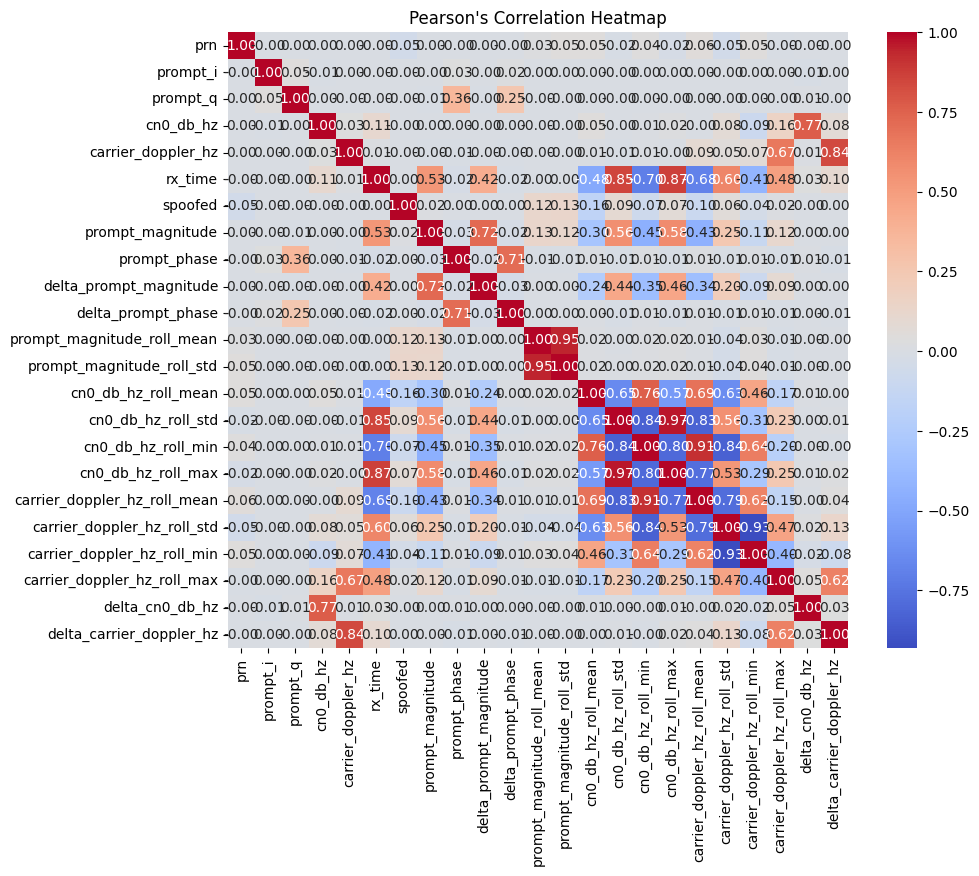

In [236]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [237]:
big_df_no_diff.drop(columns=['prn'], inplace=True)
big_df.drop(columns=['prn'], inplace=True)

KeyError: "['prn'] not found in axis"

In [238]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop('spoofed', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop('spoofed', axis=1).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [239]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop('spoofed', axis=1))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df_no_diff.drop('spoofed', axis=1).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values

In [242]:
no_extra.drop(columns=['prn'], inplace=True)

In [243]:
scaler=StandardScaler()
scaled_df_no_extra = scaler.fit_transform(no_extra.drop('spoofed', axis=1))

scaled_df_no_extra = pd.DataFrame(scaled_df_no_extra, columns=no_extra.drop('spoofed', axis=1).columns)
scaled_df_no_extra['spoofed'] = no_extra['spoofed'].values

In [240]:
scaled_df.dropna(inplace=True)
scaled_df_no_diff.dropna(inplace=True)

In [241]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [244]:
X_no_extra = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_extra = scaled_df_no_diff['spoofed']
X_train_no_extra, X_test_no_extra, y_train_no_extra, y_test_no_extra = train_test_split(X_no_extra, y_no_extra, test_size=0.2, shuffle=True)
X_train_no_extra, X_val_no_extra, y_train_no_extra, y_val_no_extra = train_test_split(X_train_no_extra, y_train_no_extra, test_size=0.2, shuffle=True)


In [99]:
X_train.shape

(121127, 21)

In [100]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,...,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz
93070,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-1.550353,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
12129,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.033832,-2.901268e-01,-0.777276,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
137984,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,1.575119,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
83011,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.461836,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
35032,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,-0.675788,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186032,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,1.021692,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
80720,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.055820,-1.999090e+00,-0.562853,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
89388,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,1.925545,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424
102741,-0.000022,0.00014,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,1.348972,...,0.207792,-0.357001,0.293884,-0.353212,0.280829,-0.186467,0.095029,-0.082471,-0.000618,-0.001424


In [101]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
6    0.147234
5    0.147019
1    0.145013
4    0.143907
2    0.141612
3    0.139085
0    0.136130
Name: proportion, dtype: float64
spoofed
5    0.146990
1    0.146673
6    0.146303
2    0.143767
4    0.142948
0    0.137136
3    0.136185
Name: proportion, dtype: float64


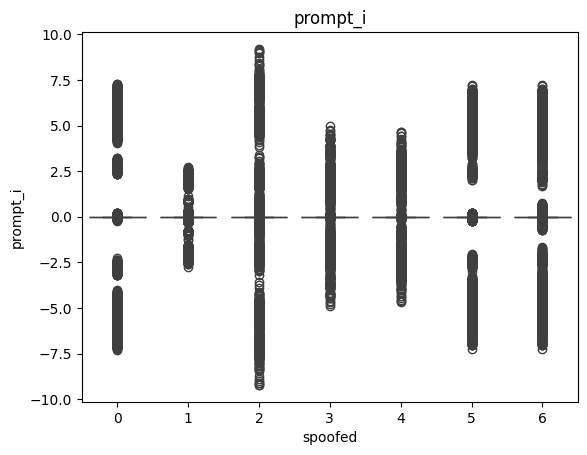

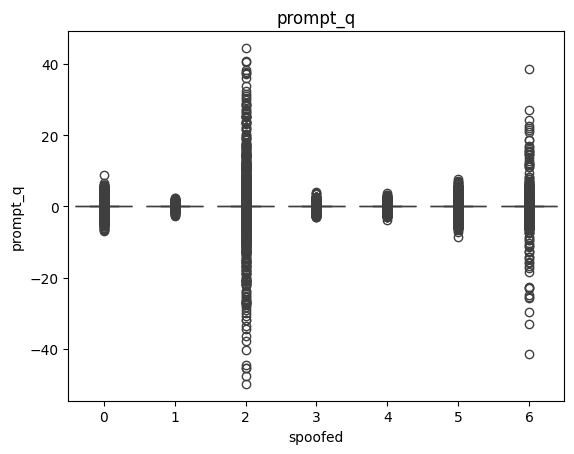

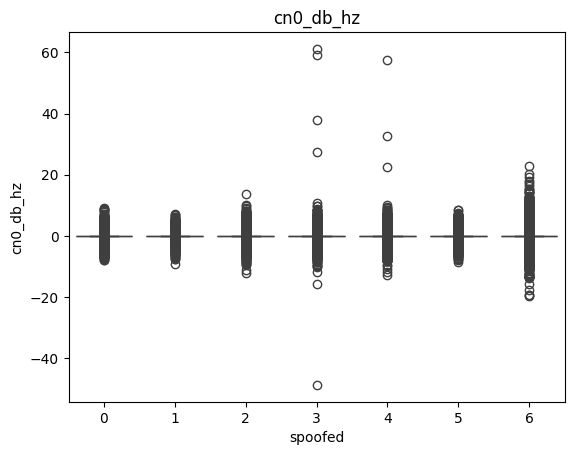

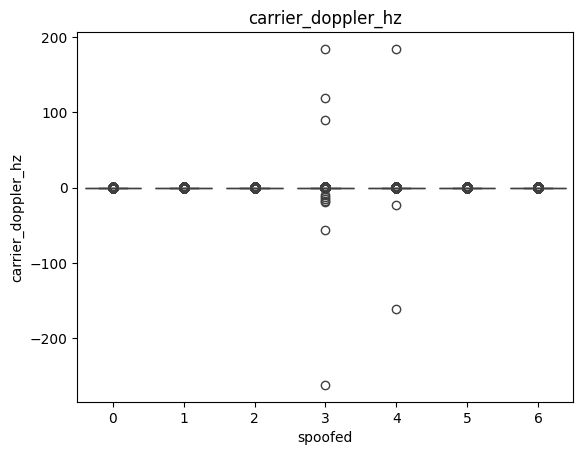

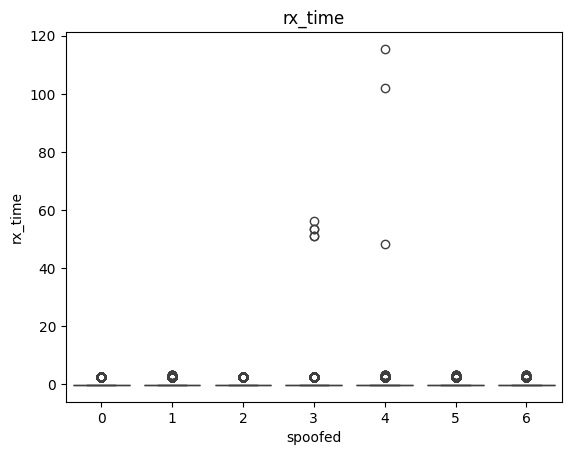

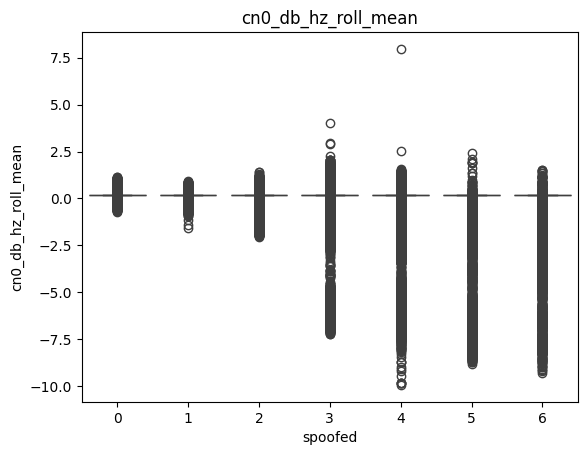

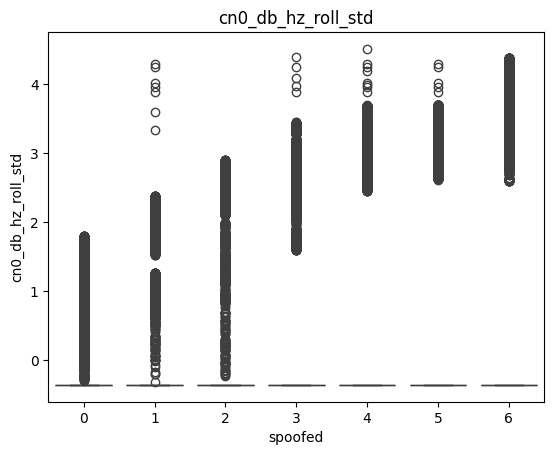

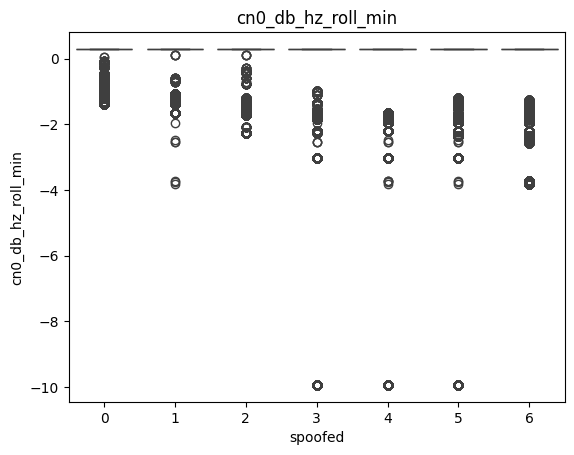

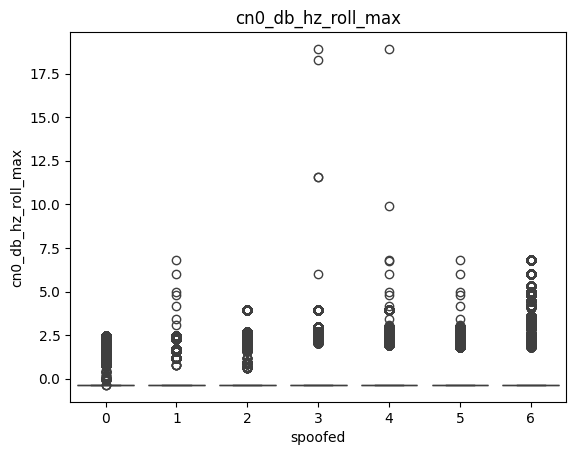

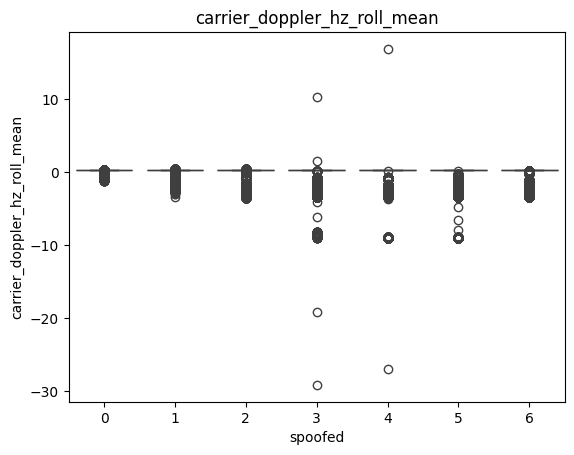

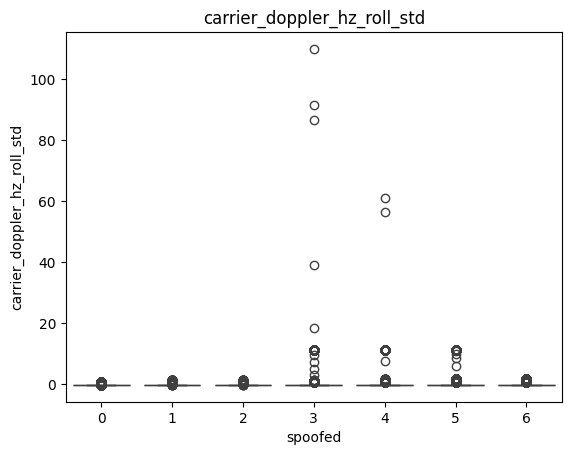

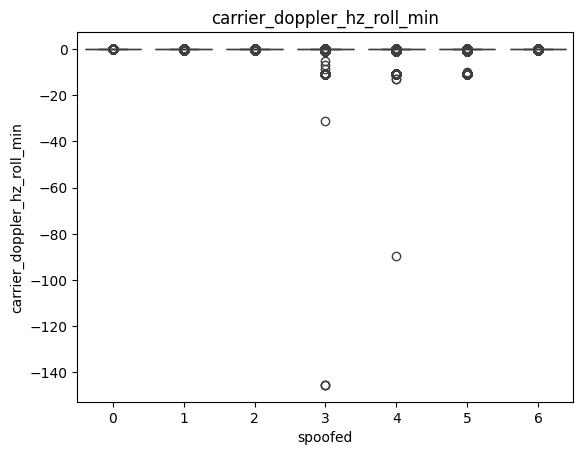

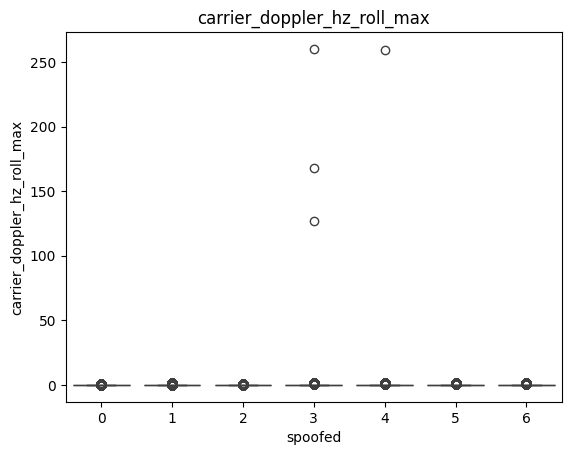

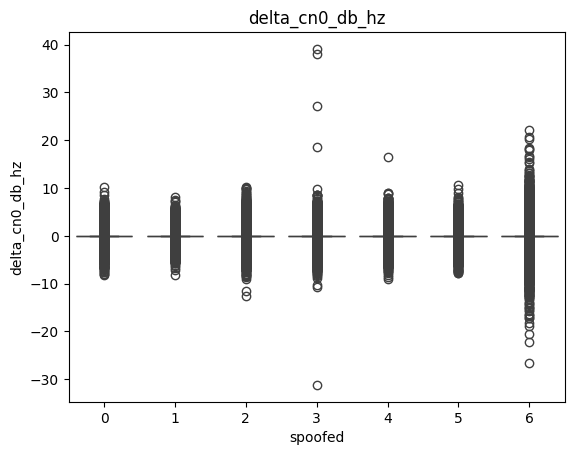

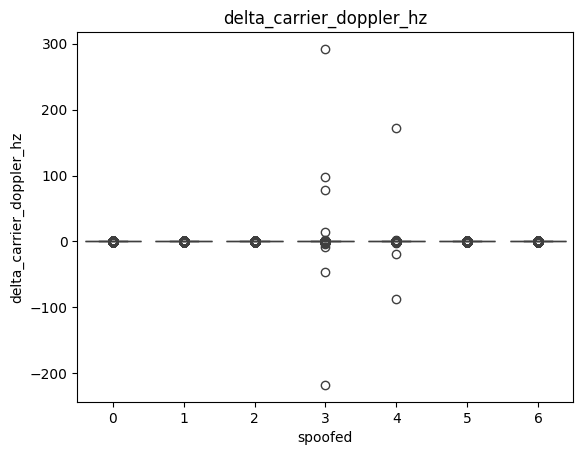

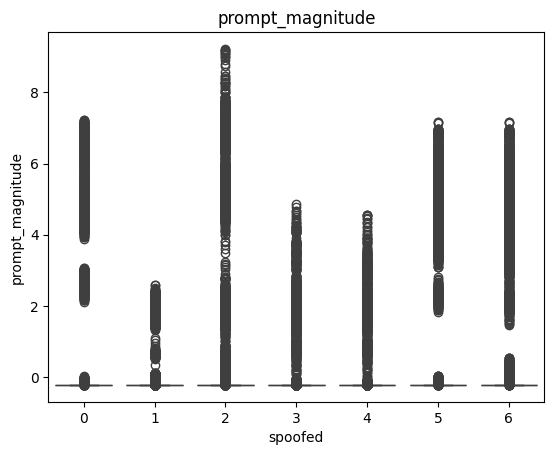

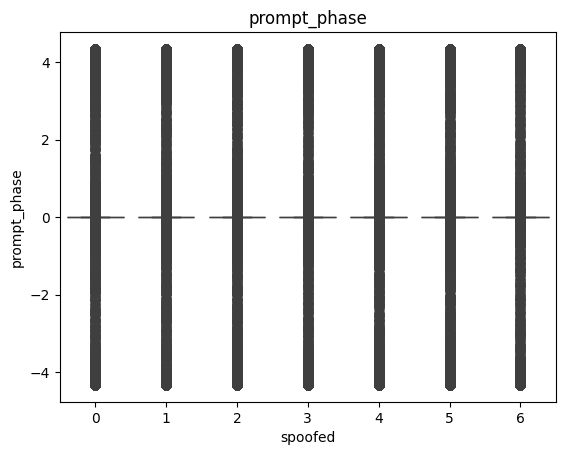

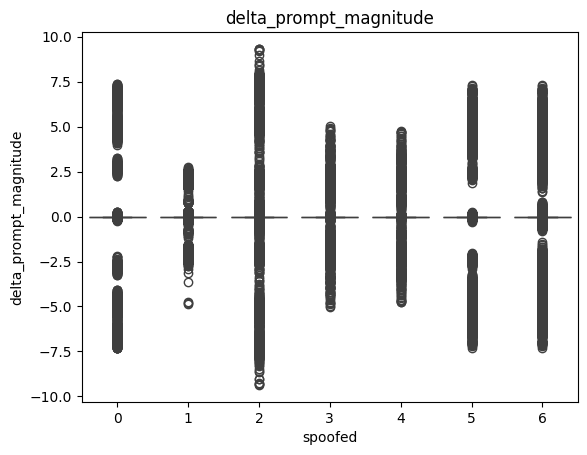

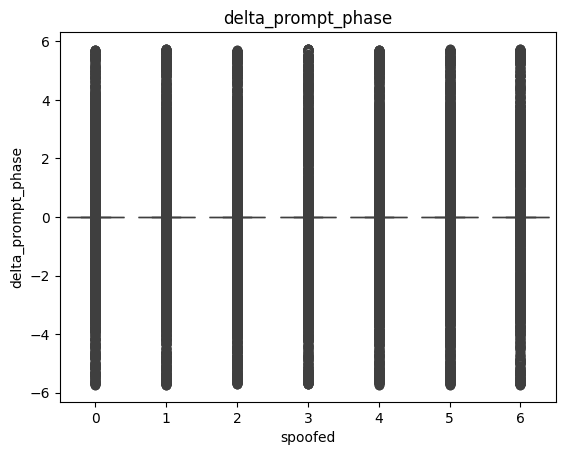

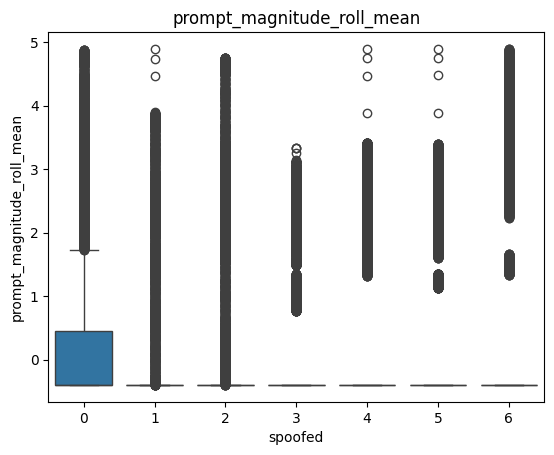

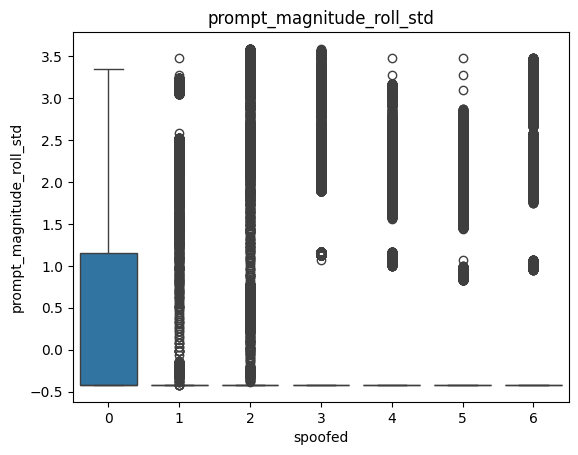

In [102]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [103]:
scaled_df.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
cn0_db_hz_roll_mean             0.162110
prompt_magnitude_roll_std       0.121816
carrier_doppler_hz_roll_mean    0.096218
cn0_db_hz_roll_std              0.092799
cn0_db_hz_roll_min              0.072840
cn0_db_hz_roll_max              0.065931
carrier_doppler_hz_roll_std     0.060658
prompt_magnitude_roll_mean      0.045012
carrier_doppler_hz_roll_min     0.036163
carrier_doppler_hz_roll_max     0.019200
prompt_magnitude                0.017238
prompt_phase                    0.002158
cn0_db_hz                       0.000674
prompt_i                        0.000152
delta_carrier_doppler_hz        0.000144
delta_prompt_magnitude          0.000107
carrier_doppler_hz              0.000099
delta_prompt_phase              0.000065
prompt_q                        0.000049
delta_cn0_db_hz                 0.000037
rx_time                         0.000037
Name: spoofed, dtype: float64

In [104]:
scaled_df_no_diff.corr()['spoofed'].abs().sort_values(ascending=False)

spoofed                         1.000000
cn0_db_hz_roll_mean             0.162110
prompt_magnitude_roll_std       0.131029
prompt_magnitude_roll_mean      0.120500
carrier_doppler_hz_roll_mean    0.096218
cn0_db_hz_roll_std              0.092799
cn0_db_hz_roll_min              0.072840
cn0_db_hz_roll_max              0.065931
carrier_doppler_hz_roll_std     0.060658
carrier_doppler_hz_roll_min     0.036163
carrier_doppler_hz_roll_max     0.019200
prompt_magnitude                0.017238
prompt_phase                    0.002158
cn0_db_hz                       0.000674
prompt_i                        0.000152
delta_carrier_doppler_hz        0.000144
carrier_doppler_hz              0.000099
prompt_q                        0.000049
delta_cn0_db_hz                 0.000037
rx_time                         0.000037
delta_prompt_magnitude          0.000012
delta_prompt_phase              0.000008
Name: spoofed, dtype: float64

In [105]:
svm = SVC(kernel='rbf', C=1, class_weight='balanced')
svm.fit(X_train, y_train)

SVC(C=1, class_weight='balanced')

In [106]:
svm_no_diff = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff.fit(X_train_no_diff, y_train_no_diff)

SVC(C=1, class_weight='balanced')

In [107]:
#PCA for SVM
pca = PCA(n_components=.95)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, shuffle=True)
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_train_pca, y_train_pca, test_size=0.2, shuffle=True)

X_no_diff_pca = pca.fit_transform(X_no_diff)
X_train_no_diff_pca, X_test_no_diff_pca, y_train_no_diff_pca, y_test_no_diff_pca = train_test_split(X_no_diff_pca, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff_pca, X_val_no_diff_pca, y_train_no_diff_pca, y_val_no_diff_pca = train_test_split(X_train_no_diff_pca, y_train_no_diff_pca, test_size=0.2, shuffle=True)

In [108]:
svm_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_pca.fit(X_train_pca, y_train_pca)

SVC(C=1, class_weight='balanced')

In [109]:
svm_no_diff_pca = SVC(kernel='rbf', C=1, class_weight='balanced')
svm_no_diff_pca.fit(X_train_no_diff_pca, y_train_no_diff_pca)

SVC(C=1, class_weight='balanced')

In [110]:
y_pred = svm.predict(X_test)

In [111]:
y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

In [112]:
y_pred_pca = svm_pca.predict(X_test_pca)

In [113]:
y_pred_no_diff_pca = svm_no_diff_pca.predict(X_test_no_diff_pca)

              precision    recall  f1-score   support

           0       0.86      0.36      0.51      5191
           1       0.90      0.12      0.22      5552
           2       0.90      0.13      0.23      5442
           3       0.81      0.10      0.17      5155
           4       0.17      0.98      0.28      5411
           5       0.83      0.10      0.18      5564
           6       0.91      0.10      0.18      5538

    accuracy                           0.27     37853
   macro avg       0.77      0.27      0.25     37853
weighted avg       0.77      0.27      0.25     37853



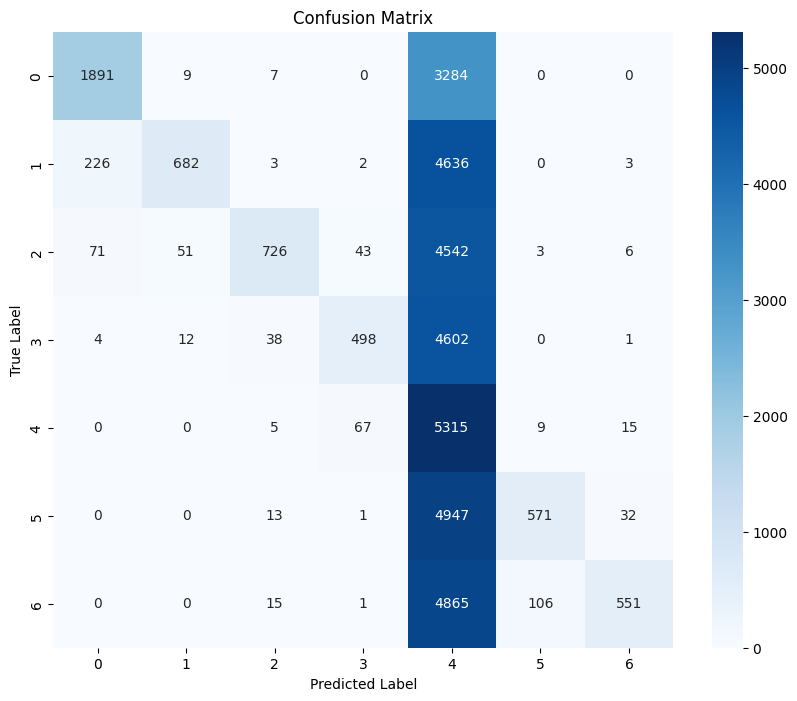

In [114]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.54      0.42      0.47      5241
           1       0.76      0.77      0.77      5549
           2       0.65      0.72      0.68      5363
           3       0.51      0.50      0.51      5239
           4       0.49      0.65      0.56      5451
           5       0.42      0.35      0.38      5517
           6       0.51      0.49      0.50      5493

    accuracy                           0.56     37853
   macro avg       0.55      0.56      0.55     37853
weighted avg       0.56      0.56      0.55     37853



Text(95.72222222222221, 0.5, 'True Label')

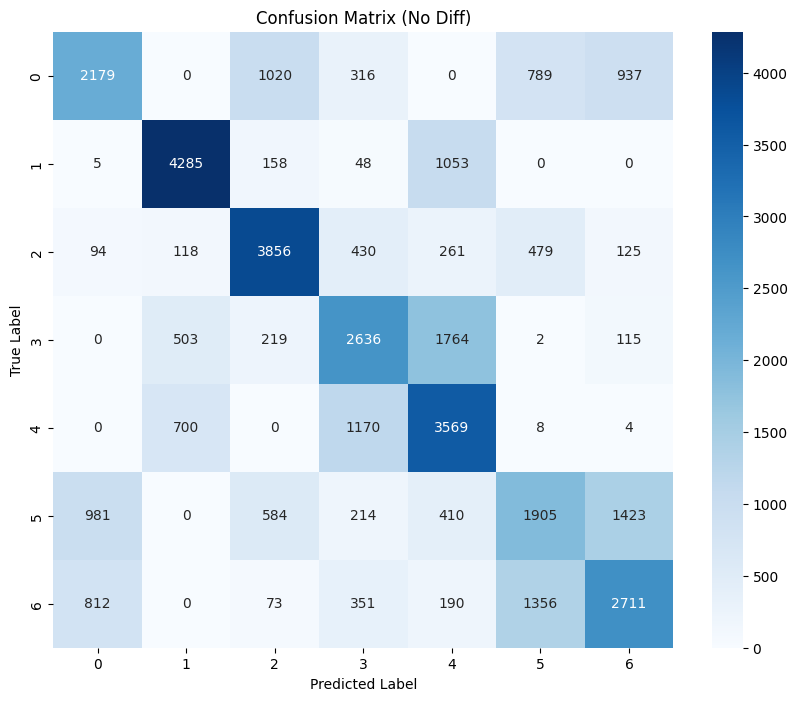

In [115]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.81      0.35      0.49      5155
           1       0.84      0.12      0.21      5506
           2       0.73      0.08      0.15      5414
           3       0.54      0.07      0.13      5184
           4       0.16      0.95      0.28      5482
           5       0.79      0.10      0.17      5598
           6       0.91      0.08      0.15      5514

    accuracy                           0.25     37853
   macro avg       0.68      0.25      0.22     37853
weighted avg       0.68      0.25      0.22     37853



Text(95.72222222222221, 0.5, 'True Label')

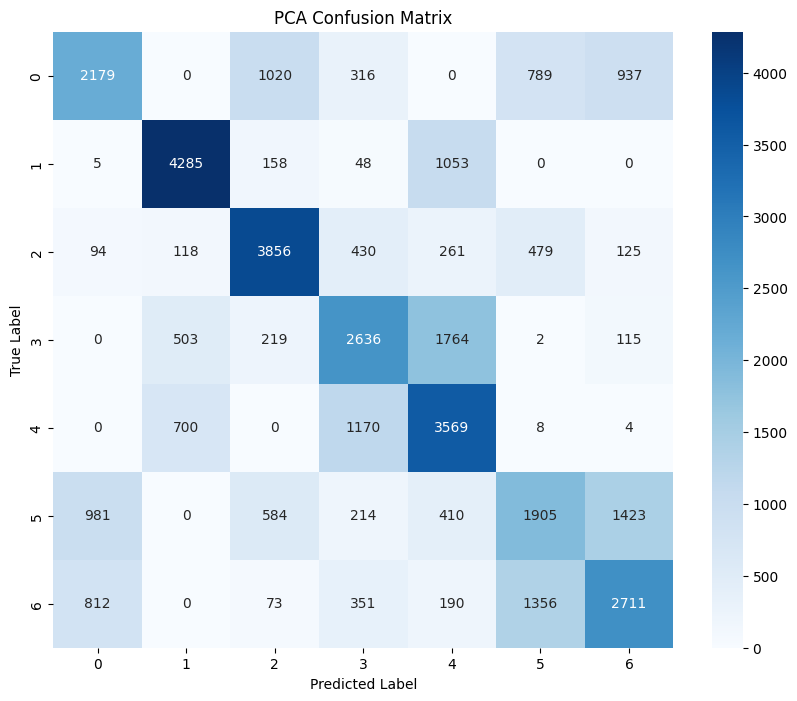

In [116]:
print(classification_report(y_test_pca, y_pred_pca))
cm_pca = confusion_matrix(y_test_pca, y_pred_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

              precision    recall  f1-score   support

           0       0.48      0.45      0.46      5172
           1       0.77      0.74      0.75      5568
           2       0.47      0.21      0.29      5323
           3       0.49      0.33      0.39      5266
           4       0.41      0.71      0.52      5396
           5       0.38      0.30      0.34      5636
           6       0.31      0.46      0.37      5492

    accuracy                           0.46     37853
   macro avg       0.47      0.46      0.45     37853
weighted avg       0.47      0.46      0.45     37853



Text(95.72222222222221, 0.5, 'True Label')

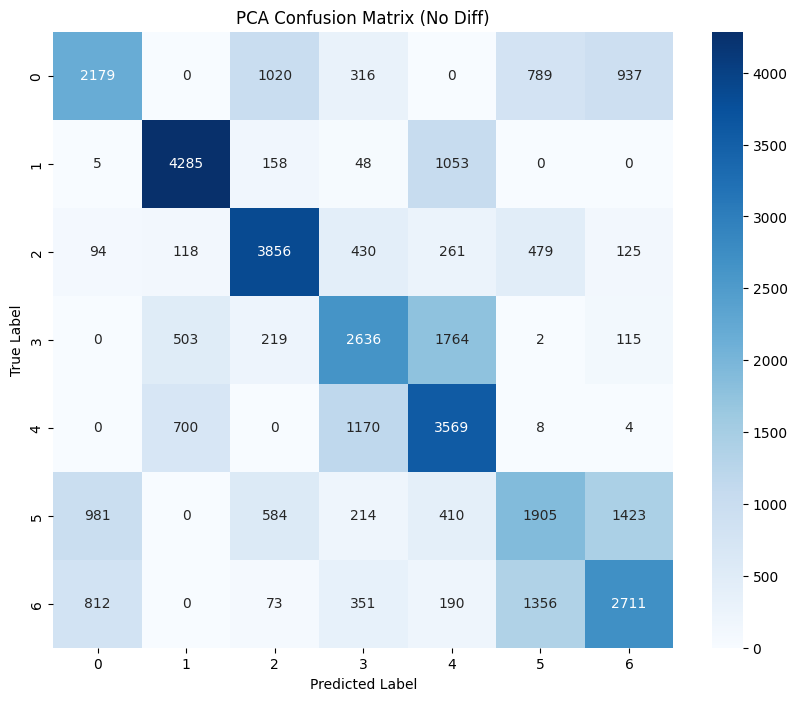

In [117]:
print(classification_report(y_test_no_diff_pca, y_pred_no_diff_pca))
cm_pca_no_diff = confusion_matrix(y_test_no_diff_pca, y_pred_no_diff_pca)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('PCA Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [118]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=12)
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=12)
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.0060
prompt_q: 0.0080
cn0_db_hz: 0.0007
carrier_doppler_hz: 0.0026
rx_time: 0.0052
cn0_db_hz_roll_mean: 0.0337
cn0_db_hz_roll_std: 0.1379
cn0_db_hz_roll_min: 0.0731
cn0_db_hz_roll_max: 0.0710
carrier_doppler_hz_roll_mean: 0.0471
carrier_doppler_hz_roll_std: 0.1197
carrier_doppler_hz_roll_min: 0.0620
carrier_doppler_hz_roll_max: 0.0636
delta_cn0_db_hz: 0.0006
delta_carrier_doppler_hz: 0.0008
prompt_magnitude: 0.0389
prompt_phase: 0.0005
delta_prompt_magnitude: 0.0138
delta_prompt_phase: 0.0010
prompt_magnitude_roll_mean: 0.1352
prompt_magnitude_roll_std: 0.1787

Random Forest No Diff
prompt_i: 0.0012
prompt_q: 0.0012
cn0_db_hz: 0.0007
carrier_doppler_hz: 0.0003
rx_time: 0.0023
cn0_db_hz_roll_mean: 0.0071
cn0_db_hz_roll_std: 0.0003
cn0_db_hz_roll_min: 0.0195
cn0_db_hz_roll_max: 0.0038
carrier_doppler_hz_roll_mean: 0.3916
carrier_doppler_hz_roll_std: 0.3781
carrier_doppler_hz_roll_min: 0.0132
carrier_doppler_hz_roll_max: 0.0444
delta_cn0_db_hz: 0.0248
delta_carri

In [119]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.87      0.39      0.53      5191
           1       1.00      0.13      0.23      5552
           2       0.99      0.15      0.26      5442
           3       0.99      0.11      0.20      5155
           4       0.17      1.00      0.29      5411
           5       1.00      0.12      0.22      5564
           6       0.99      0.13      0.23      5538

    accuracy                           0.29     37853
   macro avg       0.86      0.29      0.28     37853
weighted avg       0.86      0.29      0.28     37853



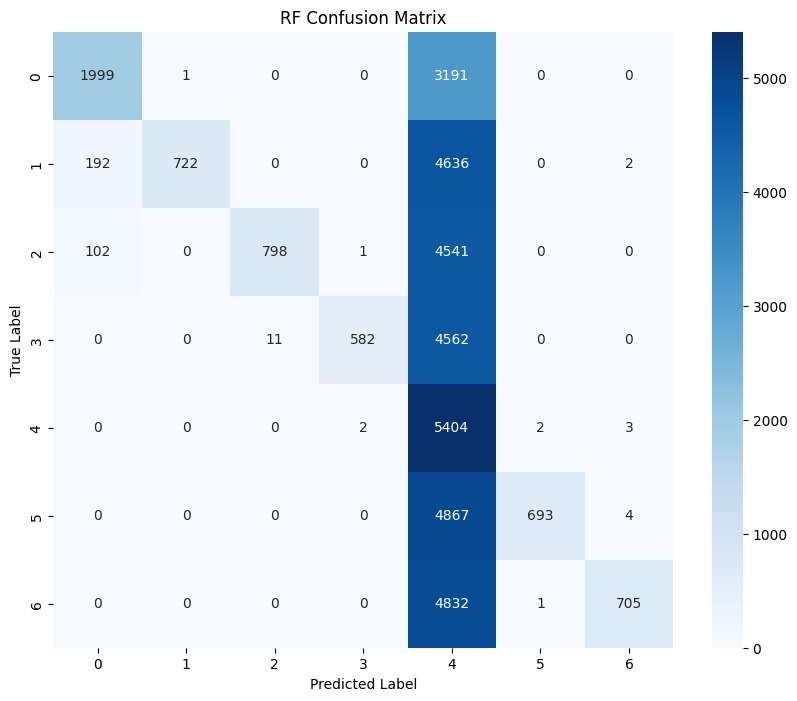

In [120]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      5241
           1       0.84      0.85      0.84      5549
           2       0.71      0.67      0.69      5363
           3       0.66      0.71      0.68      5239
           4       0.60      0.74      0.66      5451
           5       0.52      0.54      0.53      5517
           6       0.74      0.41      0.53      5493

    accuracy                           0.66     37853
   macro avg       0.67      0.66      0.66     37853
weighted avg       0.67      0.66      0.66     37853



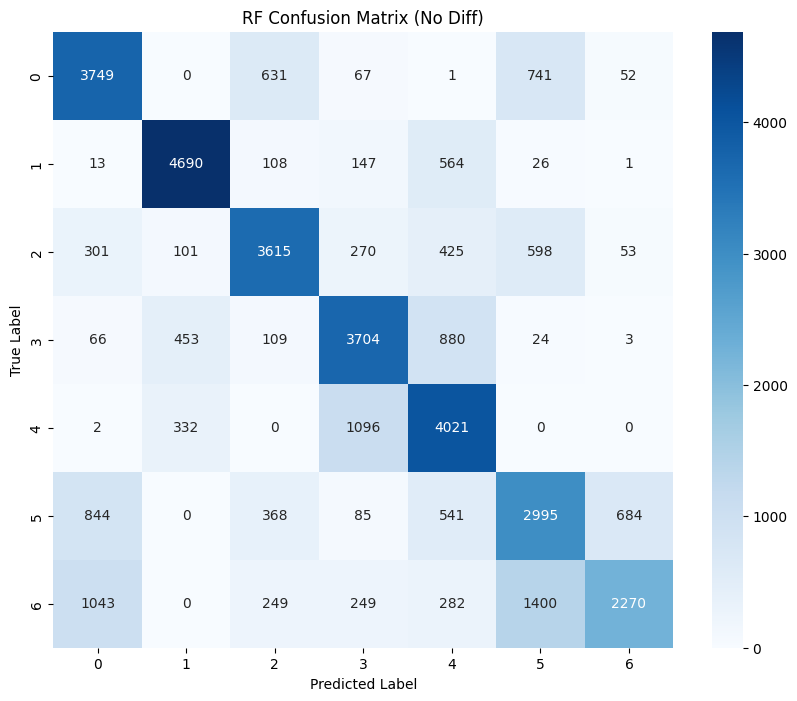

In [121]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

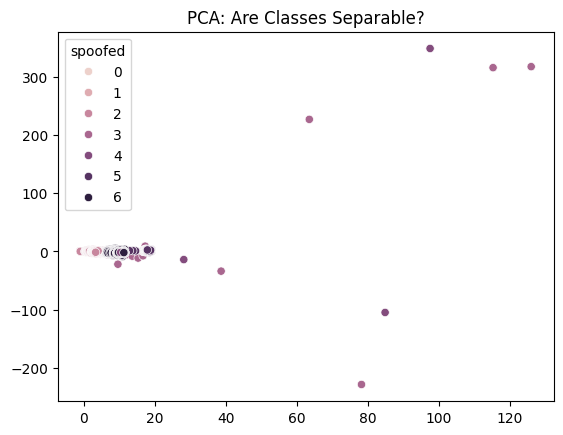

In [122]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()

In [123]:
# Hybrid XGBoost + Deep Feature Synthesis for real-time deployment.
# Implementation Framework
# python
# Preprocessing Pipeline
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
 
preprocessor = Pipeline([
#  ('feature_extractor', GPSFeatureEngineer()),
   ('imputer', KNNImputer(n_neighbors=5)),
#   ('smote', SMOTE(sampling_strategy='minority')),
   ('scaler', RobustScaler())
])
 
# XGBoost Classifier
import xgboost as xgb
xgboost_model = xgb.XGBClassifier(
  objective='binary:logistic',
  tree_method='hist',
   n_estimators=300,
   max_depth=9,
  learning_rate=0.05,
   subsample=0.8,
  colsample_bytree=0.9
)
 
# Real-Time Inference
def detect_spoofing(sample_window):
   processed = preprocessor.transform(sample_window)
   proba = xgboost_model.predict_proba(processed)[:,1]
   return (proba > 0.92).astype(int)  # Optimized threshold

X_processed = preprocessor.fit_transform(X_train)

smote = SMOTE(sampling_strategy='minority')

X_resampled, y_resampled = smote.fit_resample(X_processed, y_train)

xgboost_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [124]:
X_test_processed = preprocessor.transform(X_test)
y_pred = xgboost_model.predict(X_test_processed)

In [125]:
X_train_no_diff_processed = preprocessor.fit_transform(X_train_no_diff)
smote_no_diff = SMOTE(sampling_strategy='minority')
X_resampled_no_diff, y_resampled_no_diff = smote_no_diff.fit_resample(X_train_no_diff_processed, y_train_no_diff)

xgboost_model_no_diff = xgb.XGBClassifier(
  objective='binary:logistic',
   tree_method='hist',
   n_estimators=300,
   max_depth=9,
  learning_rate=0.05,
   subsample=0.8,
  colsample_bytree=0.9
)

xgboost_model_no_diff.fit(X_resampled_no_diff, y_resampled_no_diff)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [126]:
X_test_no_diff_processed = preprocessor.transform(X_test_no_diff)
y_pred_no_diff = xgboost_model_no_diff.predict(X_test_no_diff_processed)

              precision    recall  f1-score   support

           0       0.96      0.38      0.54      5191
           1       0.98      0.15      0.26      5552
           2       1.00      0.16      0.28      5442
           3       0.99      0.12      0.21      5155
           4       1.00      0.12      0.22      5411
           5       0.99      0.13      0.22      5564
           6       0.17      1.00      0.29      5538

    accuracy                           0.30     37853
   macro avg       0.87      0.29      0.29     37853
weighted avg       0.87      0.30      0.29     37853



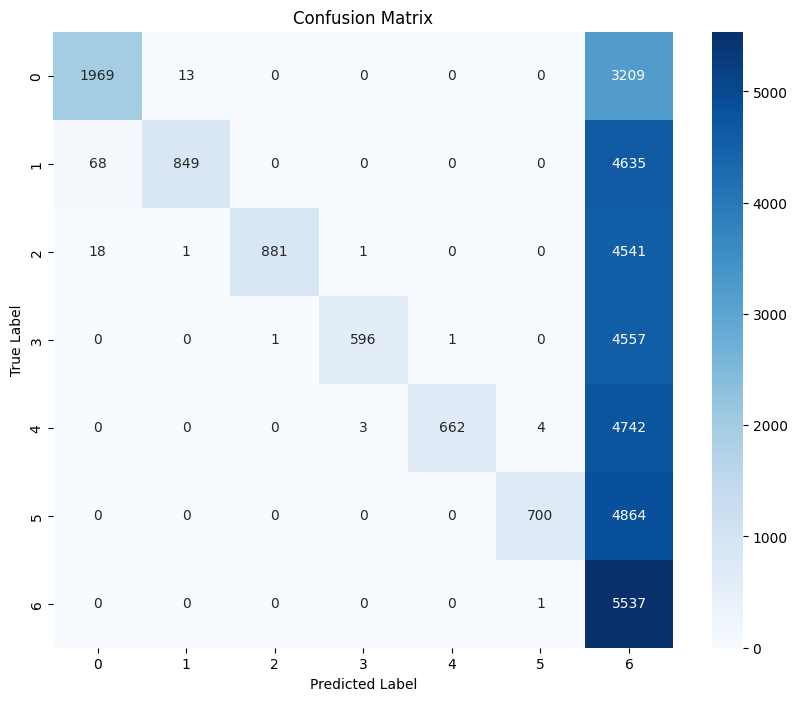

In [127]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      5241
           1       0.91      0.91      0.91      5549
           2       0.87      0.85      0.86      5363
           3       0.81      0.84      0.83      5239
           4       0.82      0.81      0.82      5451
           5       0.72      0.74      0.73      5517
           6       0.79      0.73      0.76      5493

    accuracy                           0.82     37853
   macro avg       0.82      0.82      0.82     37853
weighted avg       0.82      0.82      0.82     37853



Text(95.72222222222221, 0.5, 'True Label')

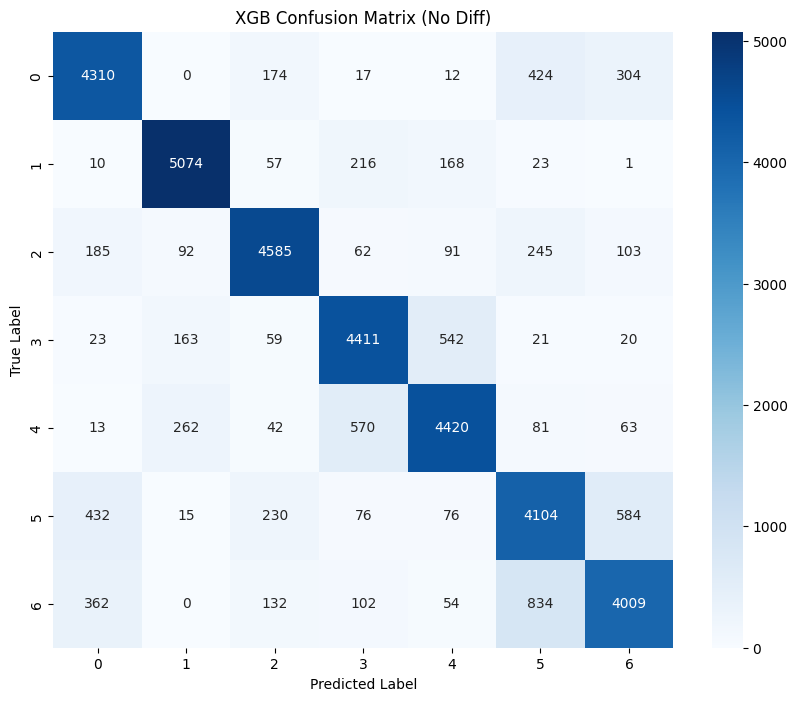

In [140]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('XGB Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [129]:
X_val_no_diff_processed = preprocessor.transform(X_val_no_diff)
y_val_no_diff_pred = xgboost_model_no_diff.predict(X_val_no_diff_processed)

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      4064
           1       0.90      0.92      0.91      4344
           2       0.88      0.87      0.87      4384
           3       0.80      0.85      0.82      4147
           4       0.84      0.80      0.82      4380
           5       0.72      0.75      0.74      4432
           6       0.79      0.74      0.77      4531

    accuracy                           0.82     30282
   macro avg       0.82      0.82      0.82     30282
weighted avg       0.82      0.82      0.82     30282



Text(95.72222222222221, 0.5, 'True Label')

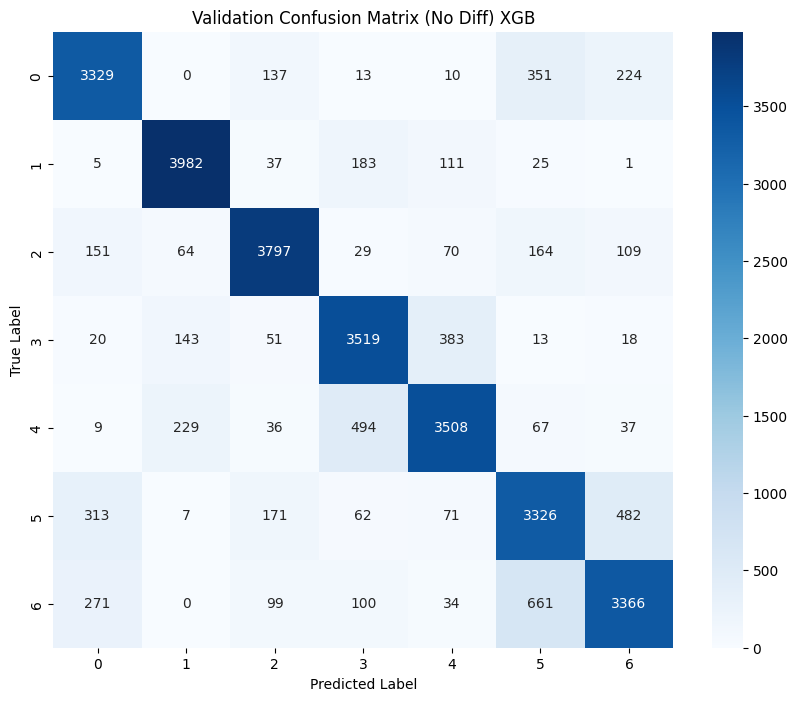

In [130]:
print(classification_report(y_val_no_diff, y_val_no_diff_pred))
cm_val_no_diff = confusion_matrix(y_val_no_diff, y_val_no_diff_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (No Diff) XGB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [131]:
y_val_no_diff_pred = rf_model_no_diff.predict(X_val_no_diff)

              precision    recall  f1-score   support

           0       0.63      0.72      0.67      4064
           1       0.84      0.85      0.84      4344
           2       0.73      0.69      0.71      4384
           3       0.66      0.72      0.69      4147
           4       0.60      0.73      0.66      4380
           5       0.53      0.55      0.54      4432
           6       0.74      0.42      0.54      4531

    accuracy                           0.66     30282
   macro avg       0.67      0.67      0.66     30282
weighted avg       0.67      0.66      0.66     30282



Text(95.72222222222221, 0.5, 'True Label')

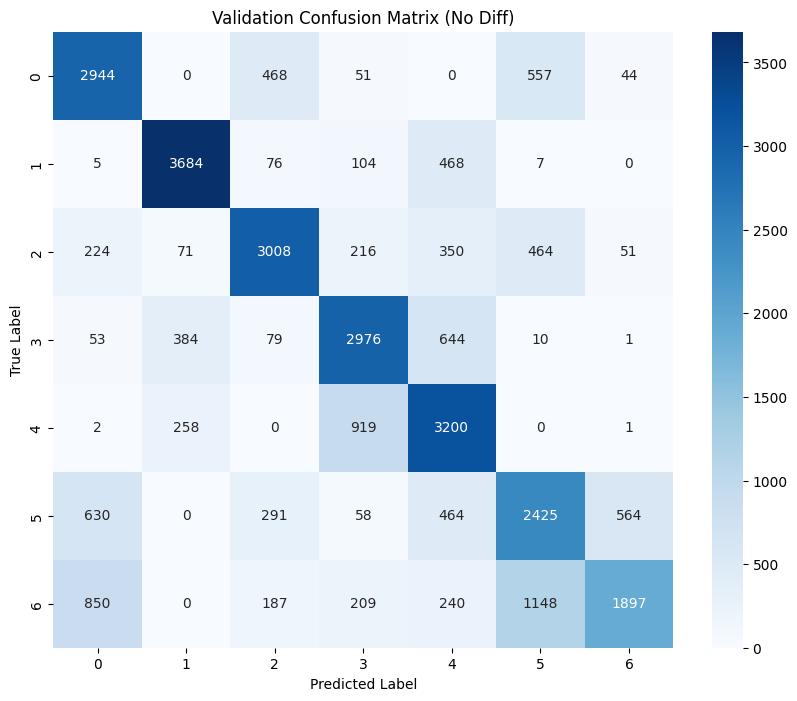

In [132]:
print(classification_report(y_val_no_diff, y_val_no_diff_pred))
cm_val_no_diff = confusion_matrix(y_val_no_diff, y_val_no_diff_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Validation Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [133]:
# LSTM
#sense change then apply classifier
# change point detection
#time feature

In [134]:
X.tail()

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,...,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,prompt_magnitude_roll_mean,prompt_magnitude_roll_std
189267,-2.284026,1.423171,2.510257,-0.062058,2.356523,0.620215,1.982086,-2.0718,2.253714,0.332126,...,-0.303703,0.669603,2.516705,-0.116698,2.116409,4.319505,2.280062,0.644334,0.480095,0.780430
189268,0.080446,-3.010753,1.348353,0.242437,2.356523,0.709436,1.982756,-2.0718,2.253714,0.358989,...,-0.303703,0.669603,-0.766871,0.251759,-0.116460,-0.951330,-2.222062,-3.493984,0.480287,0.780363
189269,-0.050734,2.344040,-1.145022,-0.164687,2.356523,0.633488,1.983252,-2.0718,2.253714,0.340257,...,-0.303703,0.669603,-1.644950,-0.339941,-0.149199,3.236715,-0.032580,2.776189,0.480421,0.780315
189270,2.277118,-1.628454,3.023877,-0.040324,2.356523,0.833701,1.986638,-2.0718,2.253714,0.335453,...,-0.303703,0.669603,2.748689,0.101982,2.109447,-0.016357,2.247714,-2.156434,0.484601,0.782569
189271,-0.030007,0.386278,-5.098835,-0.065308,2.356523,0.495839,1.996330,-2.0718,2.253714,0.327851,...,-0.303703,0.669603,-5.357388,-0.022197,-0.191731,3.954077,-2.290040,2.631936,0.484658,0.782547


In [135]:
# Reshape data for LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_train_no_diff_lstm = X_train_no_diff.values.reshape((X_train_no_diff.shape[0], 1, X_train_no_diff.shape[1]))
X_test_no_diff_lstm = X_test_no_diff.values.reshape((X_test_no_diff.shape[0], 1, X_test_no_diff.shape[1]))
X_val_no_diff_lstm = X_val_no_diff.values.reshape((X_val_no_diff.shape[0], 1, X_val_no_diff.shape[1]))


In [245]:
X_train_no_extra_lstm = X_train_no_extra.values.reshape((X_train_no_extra.shape[0], 1, X_train_no_extra.shape[1]))
X_test_no_extra_lstm = X_test_no_extra.values.reshape((X_test_no_extra.shape[0], 1, X_test_no_extra.shape[1]))
X_val_no_extra_lstm = X_val_no_extra.values.reshape((X_val_no_extra.shape[0], 1, X_val_no_extra.shape[1]))


In [169]:
X_train_lstm.shape

(121127, 1, 21)

In [255]:
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)  # Increased dropout
    # x = LSTM(25, return_sequences=False)(x)
    x = Dropout(0.3)(x)  # Increased dropout
    x = Dense(15, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch Normalization
    outputs = Dense(7, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.001)  # Lower learning rate
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [214]:
# Train LSTM model
lstm_model.fit(X_train_lstm, y_train, 
               validation_data=(X_val_lstm, y_val), 
               epochs=50, 
               batch_size=500, 
               verbose=1)


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2967 - loss: 1.6122 - val_accuracy: 0.2959 - val_loss: 1.6194
Epoch 2/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2951 - loss: 1.6114 - val_accuracy: 0.2975 - val_loss: 1.6159
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2970 - loss: 1.6101 - val_accuracy: 0.2973 - val_loss: 1.6155
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2979 - loss: 1.6093 - val_accuracy: 0.2962 - val_loss: 1.6191
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2944 - loss: 1.6140 - val_accuracy: 0.2972 - val_loss: 1.6170
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2971 - loss: 1.6119 - val_accuracy: 0.2973 - val_loss: 1.6164
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2969 - loss: 1.6097 - val_accuracy: 0.2974 - val_loss: 1.6161
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2977 - loss: 1.6098 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.2938 - loss: 1.6352
LSTM Test Loss: 1.6372, Test Accuracy: 0.2919
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step
              precision    recall  f1-score   support

           0       0.96      0.38      0.55      5191
           1       0.99      0.15      0.26      5552
           2       0.95      0.16      0.28      5442
           3       0.93      0.11      0.19      5155
           4       0.93      0.11      0.20      5411
           5       0.17      0.98      0.29      5564
           6       0.91      0.13      0.22      5538

    accuracy                           0.29     37853
   macro avg       0.84      0.29      0.29     37853
weighted avg       0.83      0.29      0.28     37853



Text(95.72222222222221, 0.5, 'True Label')

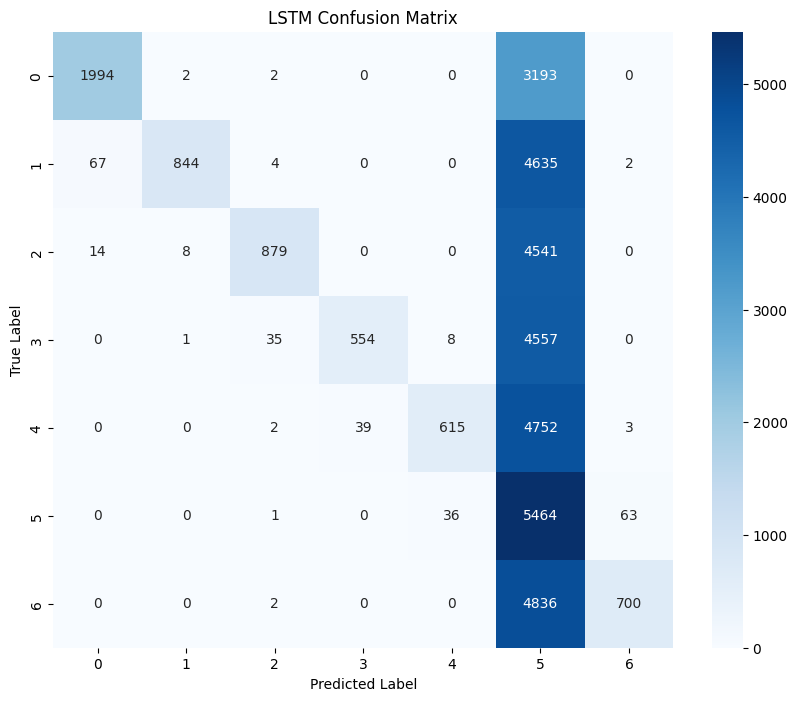

In [215]:
# Evaluate LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"LSTM Test Loss: {lstm_loss:.4f}, Test Accuracy: {lstm_accuracy:.4f}")
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
print(classification_report(y_test, y_pred_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [216]:
lstm_model_no_diff = create_lstm_model((X_train_no_diff_lstm.shape[1], X_train_no_diff_lstm.shape[2]))
lstm_model_no_diff.summary()

# Train LSTM model
lstm_model_no_diff.fit(X_train_no_diff_lstm, y_train_no_diff, 
               validation_data=(X_val_no_diff_lstm, y_val_no_diff), 
               epochs=10, 
               batch_size=500, 
               verbose=1)


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_35 (InputLayer)     │ (None, 1, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 1, 50)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1, 15)          │           765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 15)          │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1, 7)           │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,337 (59.91 KB)

 Trainable params: 15,307 (59.79 KB)

 Non-trainable params: 30 (120.00 B)

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3226 - loss: 1.7179 - val_accuracy: 0.4112 - val_loss: 1.4750
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4574 - loss: 1.3085 - val_accuracy: 0.5231 - val_loss: 1.2064
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5104 - loss: 1.2022 - val_accuracy: 0.5533 - val_loss: 1.1105
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5294 - loss: 1.1478 - val_accuracy: 0.5531 - val_loss: 1.0779
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5363 - loss: 1.1210 - val_accuracy: 0.5545 - val_loss: 1.0561
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5410 - loss: 1.1002 - val_accuracy: 0.5717 - val_loss: 1.0430
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5466 - loss: 1.0896 - val_accuracy: 0.5650 - val_loss: 1.0323
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5531 - loss: 1.0714 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 482us/step - accuracy: 0.1465 - loss: 4.1990
LSTM Test Loss: 4.1822, Test Accuracy: 0.1471
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
              precision    recall  f1-score   support

           0       0.15      0.11      0.13      5257
           1       0.15      0.15      0.15      5423
           2       0.15      0.15      0.15      5393
           3       0.14      0.12      0.13      5204
           4       0.14      0.21      0.17      5485
           5       0.15      0.12      0.14      5541
           6       0.15      0.16      0.16      5550

    accuracy                           0.15     37853
   macro avg       0.15      0.15      0.15     37853
weighted avg       0.15      0.15      0.15     37853



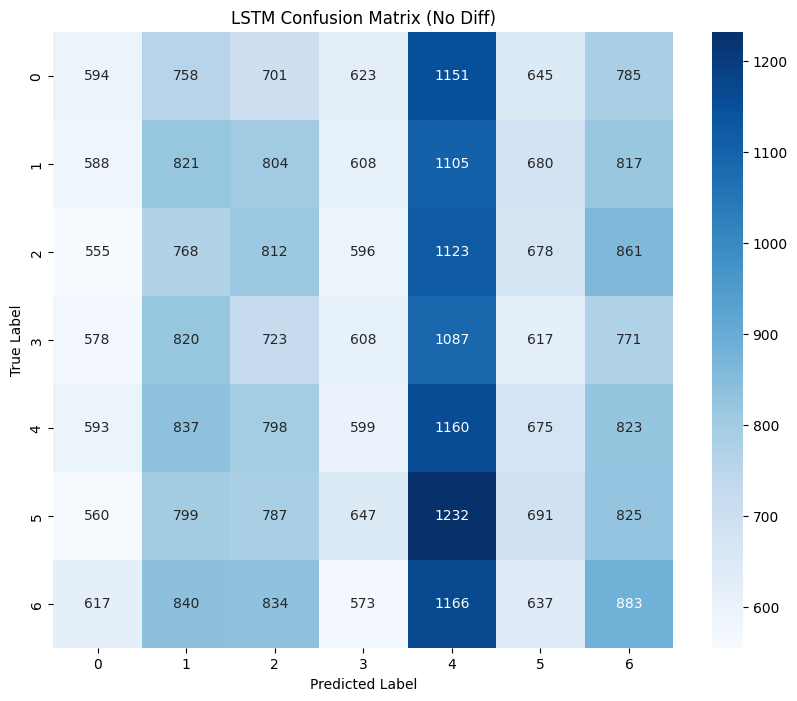

In [266]:
# Evaluate LSTM model
lstm_no_diff_loss, lstm_no_diff_accuracy = lstm_model_no_diff.evaluate(X_test_no_diff_lstm, y_test, verbose=1)
print(f"LSTM Test Loss: {lstm_no_diff_loss:.4f}, Test Accuracy: {lstm_no_diff_accuracy:.4f}")
y_pred_no_diff_lstm = np.argmax(lstm_model_no_diff.predict(X_test_no_diff_lstm), axis=2)
print(classification_report(y_test, y_pred_no_diff_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_no_diff_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [256]:
lstm_model_no_extra = create_lstm_model((X_train_no_extra_lstm.shape[1], X_train_no_extra_lstm.shape[2]))
lstm_model_no_extra.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 1, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 1, 50)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 1, 15)          │           765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 15)          │            60 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1, 7)           │           112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,337 (59.91 KB)

 Trainable params: 15,307 (59.79 KB)

 Non-trainable params: 30 (120.00 B)

In [257]:
lstm_model_no_extra.fit(X_train_no_extra_lstm, y_train_no_extra,
               validation_data=(X_val_no_extra_lstm, y_val_no_extra), 
               epochs=10, 
               batch_size=500, 
               verbose=1)

Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2772 - loss: 1.7983 - val_accuracy: 0.4162 - val_loss: 1.5037
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4566 - loss: 1.3119 - val_accuracy: 0.5442 - val_loss: 1.1993
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5159 - loss: 1.1824 - val_accuracy: 0.5482 - val_loss: 1.0899
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5276 - loss: 1.1404 - val_accuracy: 0.5524 - val_loss: 1.0660
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5371 - loss: 1.1150 - val_accuracy: 0.5678 - val_loss: 1.0422
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5426 - loss: 1.1015 - val_accuracy: 0.5656 - val_loss: 1.0328
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5471 - loss: 1.0849 - val_accuracy: 0.5740 - val_loss: 1.0236
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5468 - loss: 1.0796 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
(37853, 1, 7)
(37853, 1)
(37853,)
              precision    recall  f1-score   support

           0       0.14      0.12      0.13      5257
           1       0.15      0.16      0.15      5423
           2       0.14      0.14      0.14      5393
           3       0.14      0.11      0.12      5204
           4       0.15      0.22      0.18      5485
           5       0.14      0.13      0.13      5541
           6       0.14      0.13      0.13      5550

    accuracy                           0.14     37853
   macro avg       0.14      0.14      0.14     37853
weighted avg       0.14      0.14      0.14     37853



Text(95.72222222222221, 0.5, 'True Label')

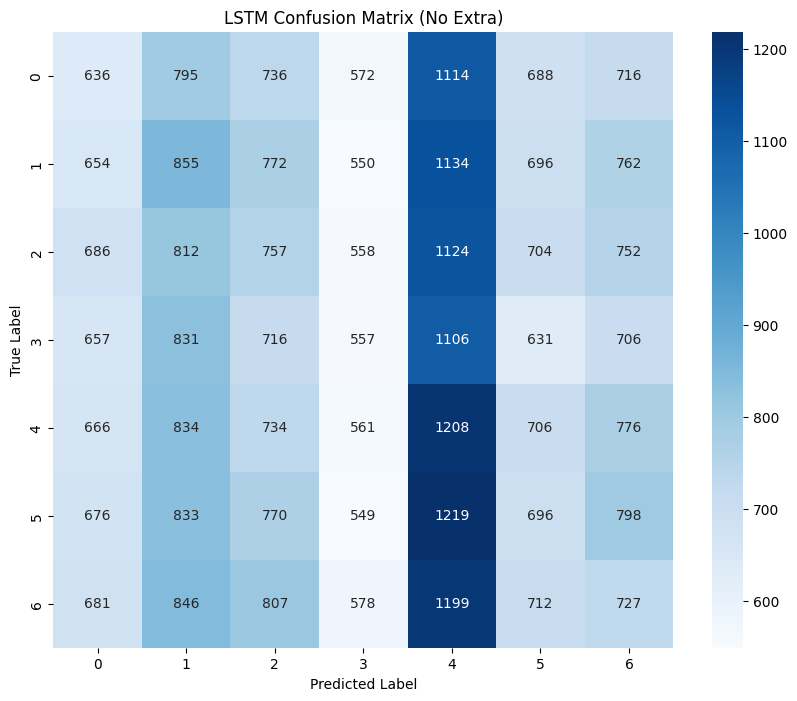

In [265]:
y_pred_no_extra_lstm = lstm_model_no_extra.predict(X_test_no_extra_lstm)
print(y_pred_no_extra_lstm.shape)
y_pred_no_extra_lstm = np.argmax(y_pred_no_extra_lstm, axis=2)
print(y_pred_no_extra_lstm.shape)
print(y_test.shape)
print(classification_report(y_test, y_pred_no_extra_lstm))
cm_lstm = confusion_matrix(y_test, y_pred_no_extra_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('LSTM Confusion Matrix (No Extra)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [224]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, Input


def create_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)  # (1, 21)
    
    # CNN part: learn patterns across the 21 features
    x = Conv1D(32, 1, activation='relu')(inputs)
    #x = MaxPooling1D(1)(x)
    x = Dropout(0.3)(x)
    
    # LSTM part: capture sequential relationships (though only 1 timestep here)
    x = LSTM(50)(x)
    
    # Fully connected part
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(7, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [225]:
cnn_lstm_model = create_cnn_lstm_model((X_train_no_diff_lstm.shape[1], X_train_no_diff_lstm.shape[2]))
cnn_lstm_model.summary()

# Train CNN-LSTM model
cnn_lstm_model.fit(X_train_no_diff_lstm, y_train_no_diff, 
               validation_data=(X_val_no_diff_lstm, y_val_no_diff), 
               epochs=25, 
               batch_size=500, 
               verbose=1)

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_38 (InputLayer)     │ (None, 1, 21)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 1, 32)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,023 (82.12 KB)

 Trainable params: 21,023 (82.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3059 - loss: 1.6805 - val_accuracy: 0.4439 - val_loss: 1.2787
Epoch 2/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4324 - loss: 1.3256 - val_accuracy: 0.5064 - val_loss: 1.1948
Epoch 3/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4789 - loss: 1.2455 - val_accuracy: 0.5455 - val_loss: 1.0954
Epoch 4/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5150 - loss: 1.1603 - val_accuracy: 0.5595 - val_loss: 1.0484
Epoch 5/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5299 - loss: 1.1157 - val_accuracy: 0.5649 - val_loss: 1.0261
Epoch 6/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5382 - loss: 1.0843 - val_accuracy: 0.5699 - val_loss: 1.0042
Epoch 7/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5442 - loss: 1.0628 - val_accuracy: 0.5715 - val_loss: 0.9849
Epoch 8/25
243/243 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5465 - loss: 1.0446 - val_accuracy: 0.

1183/1183 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step
              precision    recall  f1-score   support

           0       0.14      0.08      0.10      5191
           1       0.14      0.11      0.12      5552
           2       0.14      0.14      0.14      5442
           3       0.14      0.19      0.16      5155
           4       0.14      0.15      0.15      5411
           5       0.14      0.11      0.12      5564
           6       0.14      0.20      0.16      5538

    accuracy                           0.14     37853
   macro avg       0.14      0.14      0.14     37853
weighted avg       0.14      0.14      0.14     37853



Text(95.72222222222221, 0.5, 'True Label')

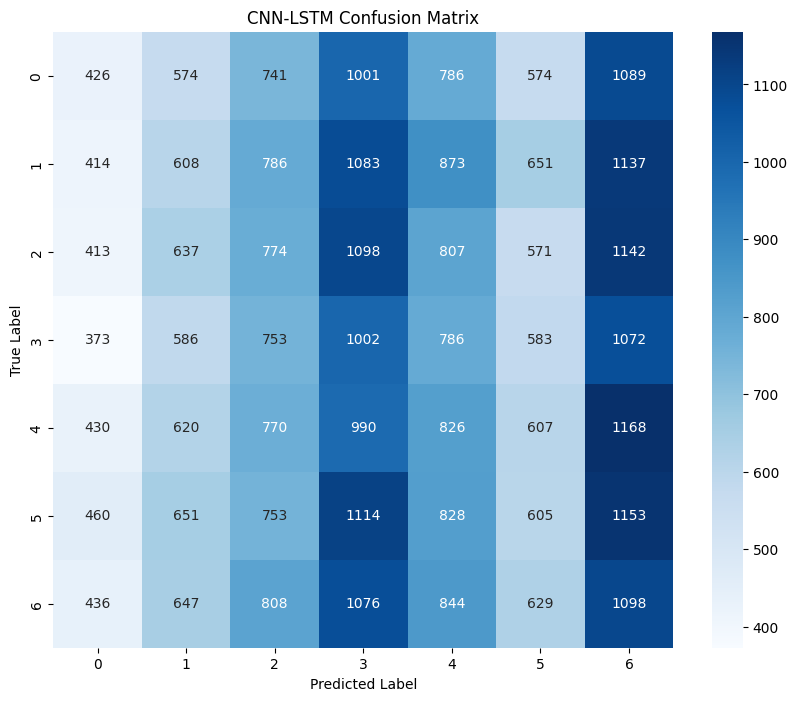

In [226]:
y_pred_cnn_lstm = np.argmax(cnn_lstm_model.predict(X_test_no_diff_lstm), axis=1)
print(classification_report(y_test, y_pred_cnn_lstm))
cm_cnn_lstm = confusion_matrix(y_test, y_pred_cnn_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cnn_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('CNN-LSTM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')